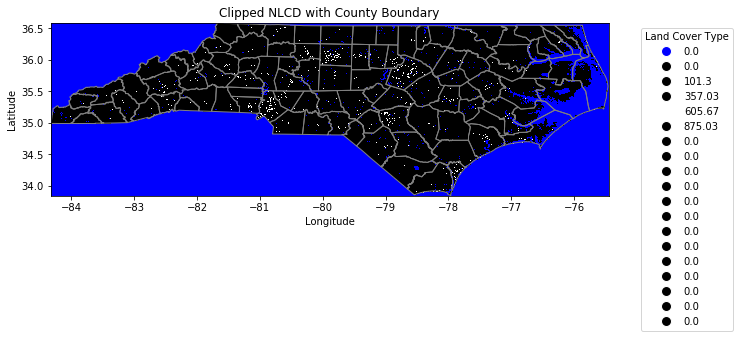

In [10]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors
from matplotlib import cm

# Define the value-to-name mapping
value_to_name = {
    11: 0.0,
    12: 0.0,
    21: 101.3,
    22: 357.03,
    23: 605.67,
    24: 875.03,
    31: 0.0,
    41: 0.0,
    42: 0.0,
    43: 0.0,
    51: 0.0,
    52: 0.0,  
    71: 0.0,
    73: 0.0,
    74: 0.0,
    81: 0.0,
    82: 0.0,
    90: 0.0,
    95: 0.0
}

# Custom color map
colors = [
    'blue', 'black', 'black', 'black', 'white', 'black', 'black',
    'black', 'black', 'black', 'black', 'black', 'black',
    'black', 'black', 'black', 'black', 'black','black'
]

# Load the shapefile
shapefile = gpd.read_file('/data/HW/HW2/NCDOT_County_Boundaries.shp')

# Ensure the shapefile's CRS is WGS84 (latitude/longitude)
shapefile = shapefile.to_crs(epsg=4326)

# Load the raster file
raster_path = '/shared_space/ACV/nlcd_nc0.1.tif'
raster = rasterio.open(raster_path)

# Get the geometry from the shapefile
shapefile_geometry = shapefile.geometry

# Convert the geometry to the appropriate format for masking
geometry = [feature.__geo_interface__ for feature in shapefile_geometry]

# Mask the raster using the shapefile geometry
out_image, out_transform = mask(raster, geometry, crop=True)

# Update metadata
out_meta = raster.meta
out_meta.update({
    "driver": "GTiff",
    "count": 1,
    "height": out_image.shape[1],
    "width": out_image.shape[2],
    "transform": out_transform
})

# Convert the raster values into discrete categories
discrete_image = np.copy(out_image[0])  # Copy the image data for discrete labeling

# Apply the mapping: replace numeric values with their corresponding discrete category
categories = np.vectorize(value_to_name.get)(discrete_image)

# Create a custom colormap based on the provided list of colors
cmap = mcolors.ListedColormap(colors)

# Create a norm for the colormap to scale the values to the correct range
bounds = list(value_to_name.keys())  # Use the dictionary keys as bounds
norm = mcolors.BoundaryNorm(bounds, cmap.N)

# Plot the raster with the discrete categories
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the discrete image using the custom colormap
cax = ax.imshow(discrete_image, cmap=cmap, norm=norm, extent=(
    out_transform[2],  # left (min longitude)
    out_transform[2] + out_transform[0] * out_image.shape[2],  # right (max longitude)
    out_transform[5] + out_transform[4] * out_image.shape[1],  # bottom (min latitude)
    out_transform[5]  # top (max latitude)
))

# Plot the shapefile boundaries on top of the raster
shapefile.plot(ax=ax, facecolor='none', edgecolor='grey')

# Set plot title and labels
ax.set_title("Clipped NLCD with County Boundary")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

# Create a custom legend for the categories
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), markersize=10) for i in range(len(value_to_name))]
labels = [value_to_name[val] for val in value_to_name]

# Add the legend to the plot
ax.legend(handles=handles, labels=labels, title="Land Cover Type", bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.show()
